Import common package

In [1]:
import os
import json
import xarray as xr
import numpy as np
import matplotlib as plt
from datetime import datetime


Import Homemade package

In [2]:
from qcat.utility.file_structure import *
from qcat.utility.io_translator import *
# from analysis.analysis_method import *


Format convert

In [3]:
from qcat.utility.file_structure import create_subfolder


raw_data_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\raw_data_pd"
output_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd"
# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

print(resonator_list)

for resonator_label in resonator_list:

    print(f"{resonator_label}")
    resonator_fd = f"{raw_data_fd}\\{resonator_label}"
    power_list = [d for d in os.listdir(resonator_fd) if os.path.isdir(os.path.join(resonator_fd, d))]

    create_subfolder(output_fd,resonator_label)
    ave_resonator_folder = f"{output_fd}\\{resonator_label}" 

    for power_label in power_list:

        # print(f"{resonator_label} {power_label}")

        power_fd = f"{resonator_fd}\\{power_label}"
        file_list = [d for d in os.listdir(power_fd) ]
        file_number = len(file_list)
        print( f"{file_number} files in {power_label}" )
        
        same_power_data = []
        
        for i, f_name in enumerate(file_list):

            # Read data
            # print(f"{i+1}/{file_number} {f_name}")
            file_fullpath = f"{power_fd}\\{f_name}"
            dataset = xr.open_dataset(file_fullpath)

            # Parse the time strings back to datetime objects
            start_time = datetime.strptime(dataset.attrs["start_time"], "%m%d_%H%M%S")
            end_time = datetime.strptime(dataset.attrs["end_time"], "%m%d_%H%M%S")
            if i==0: 
                start_time_all = start_time
                end_time_all = end_time
            if start_time < start_time_all : start_time_all = start_time
            if end_time > end_time_all : end_time_all = end_time_all


            power = dataset.attrs["power"]
            frequency = dataset.coords["frequency"]
            same_power_data.append(dataset["s21"].values)

        ave_data = np.mean( np.array(same_power_data), axis=0 )
        # print(ave_data.shape)

        # Creating an xarray dataset
        output_data = {
            "s21": ( ["s_params","frequency"],
                    np.array([ave_data[0], ave_data[1]]) )
        }
        dataset = xr.Dataset(
            output_data,
            coords={ "s_params":np.array(["real","imag"]), "frequency": frequency })
        
        dataset.attrs["power"] = power
        dataset.attrs["start_time"] = str(start_time.strftime("%m%d_%H%M%S"))
        dataset.attrs["end_time"] = str(end_time.strftime("%m%d_%H%M%S"))
        # print(dataset)
        dataset.to_netcdf(f"{ave_resonator_folder}\\{str(power)}.nc")


['C46277', 'C52463']
C46277
2 files in -20.0


2 files in -25.0
2 files in -30.0
2 files in -35.0
7 files in -40.0
25 files in -45.0
50 files in -50.0
50 files in -55.0
50 files in -60.0
C52463
2 files in -20.0
2 files in -25.0
2 files in -30.0
2 files in -35.0
7 files in -40.0
25 files in -45.0
50 files in -50.0
50 files in -55.0
50 files in -60.0


Start Analysis

Processing C46277
d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd\C46277
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
C46277 start free analysis
0 th
1 th
2 th
3 th
4 th
5 th
6 th
7 th
8 th
Saving plot at d:\Data\resonator\ITRI_364_scalinQ_new\fit_result\C46277/C46277_free.png
delay: 8.847e-17,
amp_norm: 3.723e-02,
Qc: 2.492e+05,
alpha: -4.149e-01
Saving plot at d:\Data\resonator\ITRI_364_scalinQ_new\fit_result\C46277/C46277_refined.png
Processing C52463
Create subfolder d:\Data\resonator\ITRI_364_scalinQ_new\fit_result/C52463 in result!
d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd\C52463
<class '

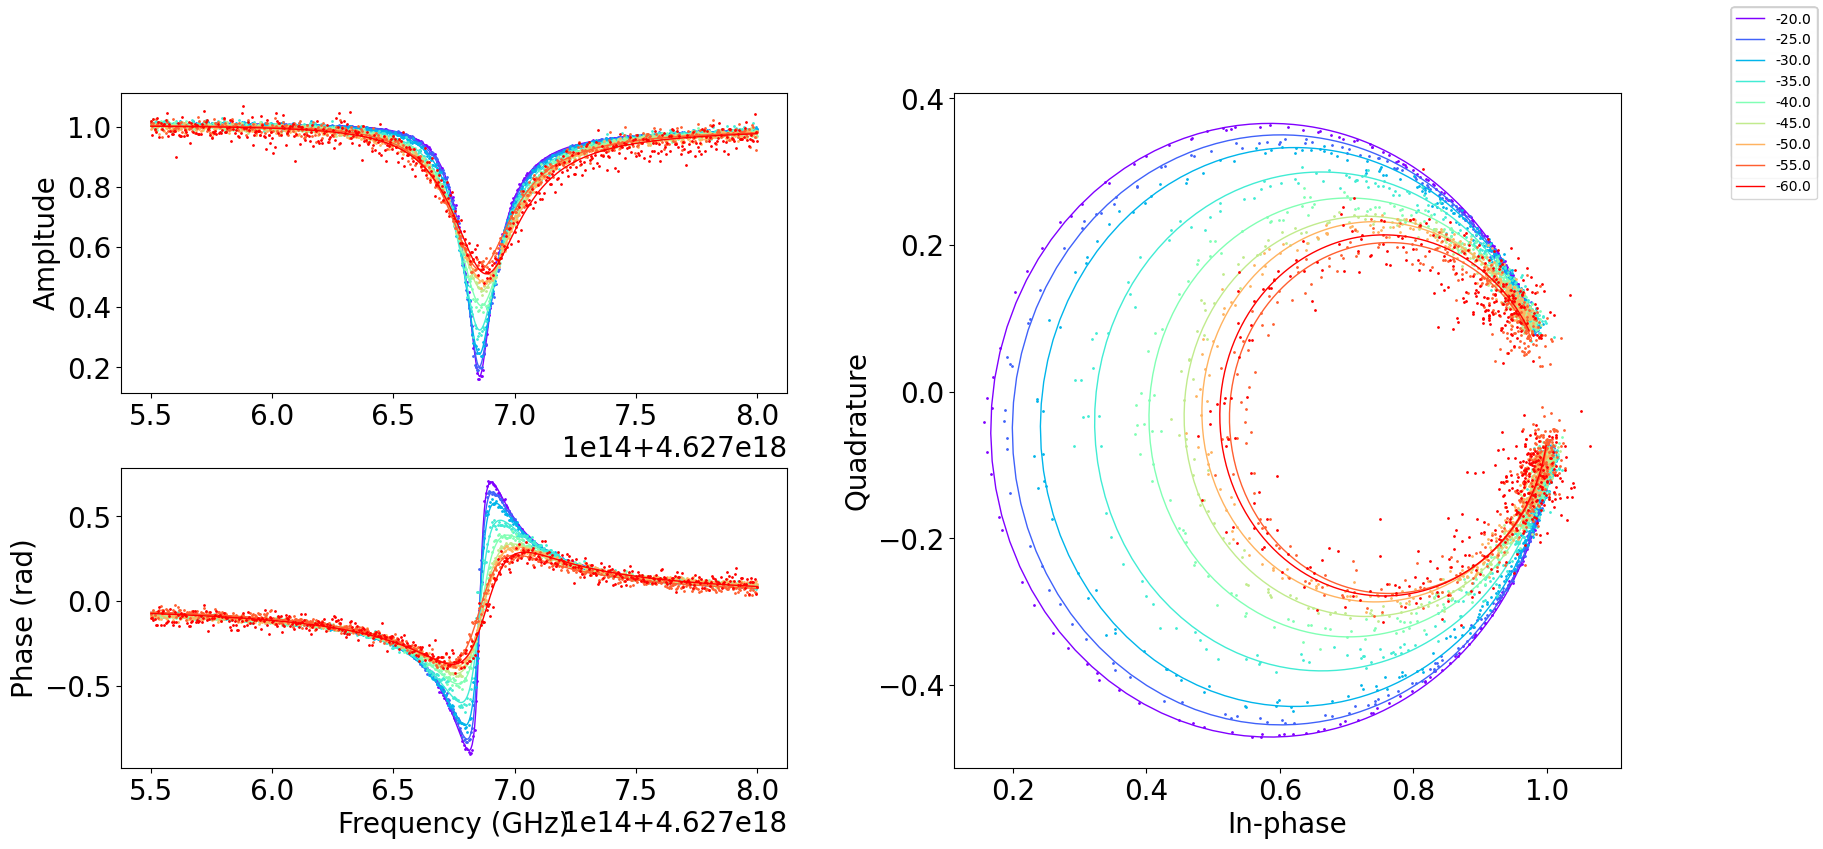

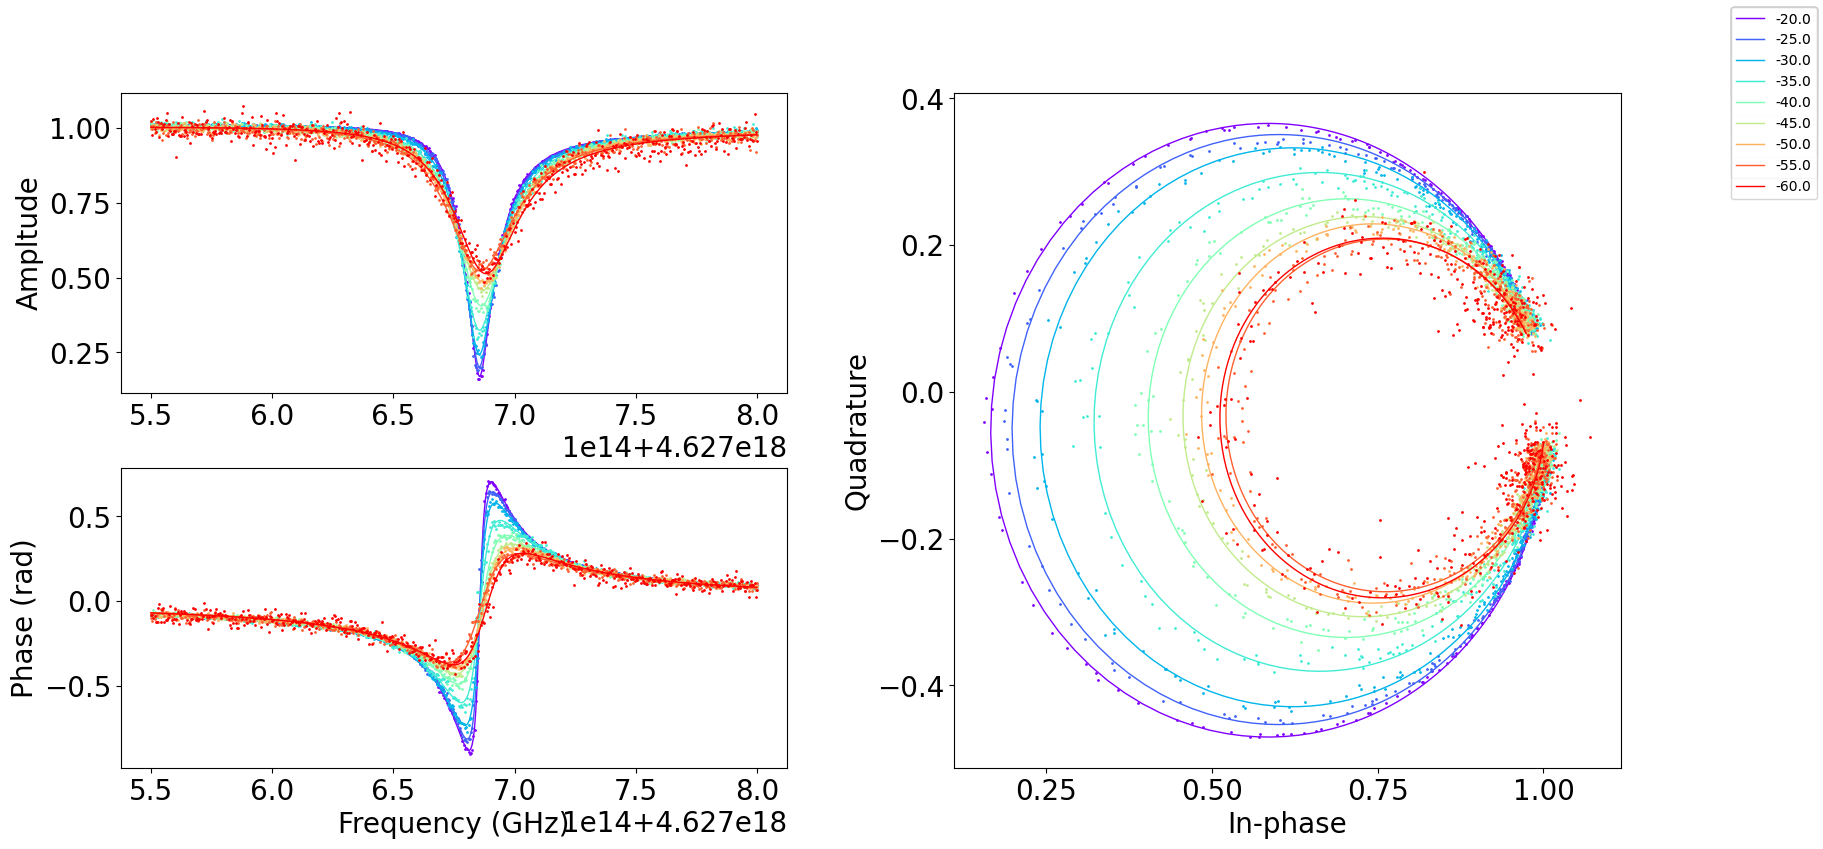

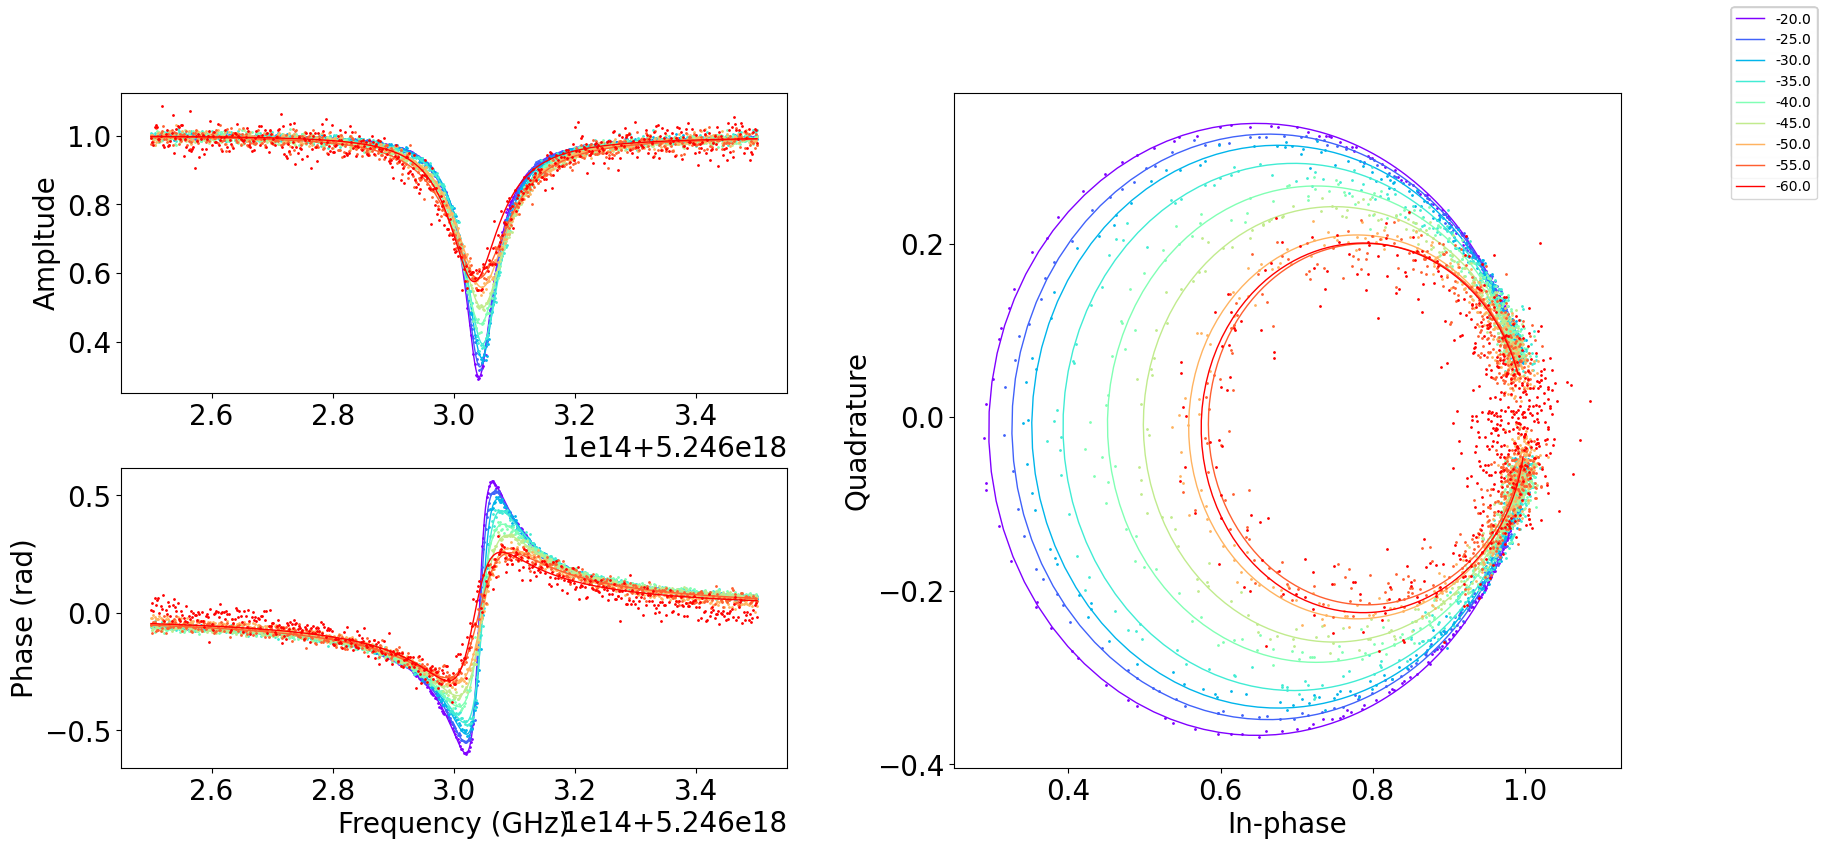

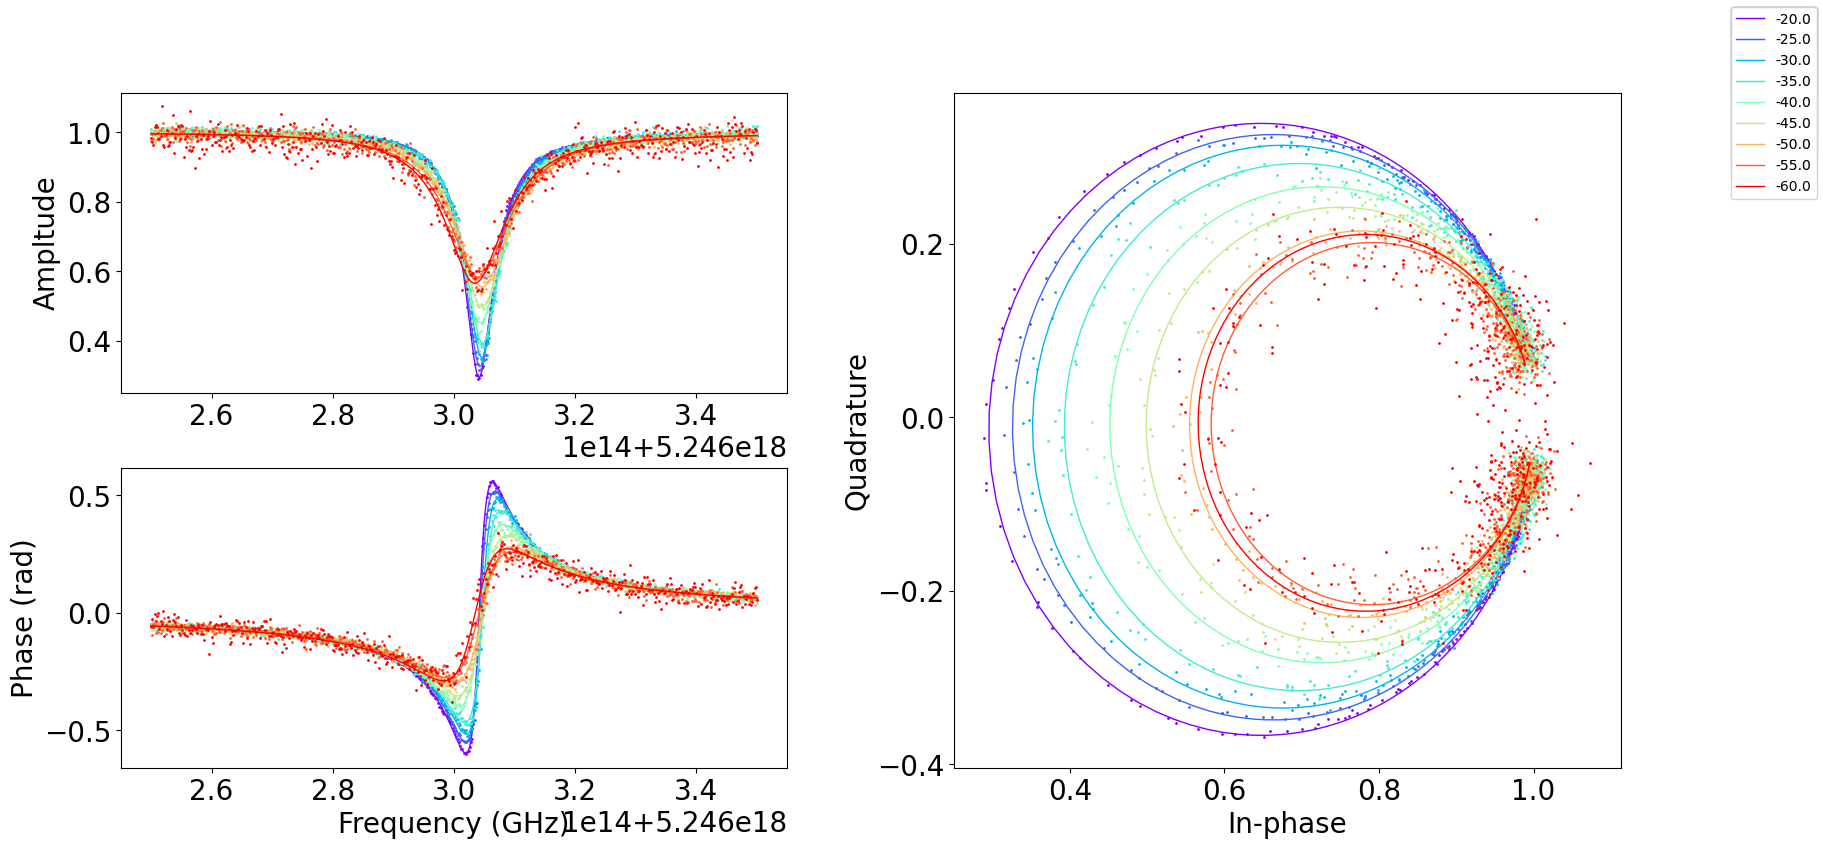

In [9]:
from qcat.resonator.photon_dep.res_data import *
from qcat.utility.file_structure import check_file_extension, create_subfolder


raw_data_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd"
output_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_result"
# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

# check_configure(f"{output_fd}", ["power_dep_fit"])

all_resonator_result = []

for resonator_label in resonator_list:
    print(f"Processing {resonator_label}")

    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    resonator_data_folder = f"{raw_data_fd}\\{resonator_label}"
    resonator = PhotonDepResonator(resonator_label)
    # Find cavity data (nc file) in the folder
    file_list = check_file_extension( resonator_data_folder, "nc")
    print(resonator_data_folder)

    for f_name in file_list:
        dataset = xr.open_dataset(f"{resonator_data_folder}\\{f_name}")
        power = dataset.attrs["power"]
        frequency = dataset.coords["frequency"].values
        data = dataset["s21"].values
        resonator.import_array(frequency, data[0]+1j*data[1], power)
    result = resonator.refined_analysis( result_folder )
    # result = resonator.free_analysis( result_folder )

    all_resonator_result.append( result )
    
    df_results = pd.concat(all_resonator_result)
    df_results.Name = resonator_label

Plot

In [15]:

plot_data_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_result"
output_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_result"
from qcat.visualization.photon_dep_loss import * 
all_resonator_result = []
folder_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

fr = []
qc = []
for resonator_label in folder_list:
    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    # Plotting
    df_powerQ_free = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\free_result.csv" )
    plot_singleRes_powerQ_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)

    df_powerQ_refined = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\refined_result.csv" )
    plot_singleRes_powerQ_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    fr.append(df_powerQ_refined["fr"].values[-1])
    qc.append(df_powerQ_refined["Qc_dia_corr_fixed"].values[-1])

# ## After assignment each cavity, get foward analysis
# assignment = pd.read_json(f"{raw_data_fd}/assignment.json")
# plot_multiRes_powerQ_free( output_fd, assignment, output_fd)
# plot_multiRes_powerQ_refined( output_fd, assignment, output_fd, ((3e-1,3e5),(1e5,5e6)))

# pd.DataFrame({"fr":np.array(fr),"Qc":np.array(qc)}).to_csv( f"{output_fd}/Qc.csv" )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

FileNotFoundError: File d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd/assignment.json does not exist